In [1]:
import os
from PIL import Image
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import CLIPModel, CLIPProcessor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm


/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

comp_prefix = "data"
train_path = comp_prefix + "/train.csv"
test_path = comp_prefix + "/test.csv"

CV = True if len(pd.read_csv(test_path)) < 10 else False

img_dir = (
    "data/train_images" if CV else "/home/hutu/workspace/MMRetrieval/data/test_images"
)
split = "valid"

use_CLIP = False
use_BGE = False
use_VisBGE = False

model2path = {
    "clip": "modeloutput/1220/Triple/checkpoint-858",
    "bge": "model/bge_base_en_v1.5",
    "reranker": "model/bge_reranker_base",
    "visbge": "model/BAAI/bge-visualized/Visualized_m3.pth",
    "marqo": "/ssd2/hutu_data/MMRetrieval/model/Marqo/marqo-ecommerce-embeddings-L",
}


## Utils function and Class

In [3]:
def visualize(df, index, col):
    """可视化图片和预测结果，预测结果为posting_id的list"""
    row = df.iloc[index]
    preds = row[col]
    img_dir: str = "data/train_images"
    images = [df[df.posting_id == pred].image.values[0] for pred in preds]

    target_title = row.title
    target_img = row.image

    titles = [df[df.posting_id == pred].title.values[0] for pred in preds]
    images = [Image.open(os.path.join(img_dir, img)) for img in images]

    rows = 5
    cols = 5
    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))

    plt.axis("off")

    for i in range(cols):
        ax[0, i].axis("off")

    for i in range(rows):
        ax[i, 0].axis("off")

    ax[0, 0].imshow(Image.open(os.path.join(img_dir, target_img)))
    ax[0, 0].set_title(
        "\n".join([target_title[i : i + 10] for i in range(0, len(target_title), 10)]),
        fontsize=12,
    )

    for i in range(1, rows):
        for j in range(1, cols):
            idx = (i - 1) * cols + (j - 1)
            ax[i, j].axis("off")
            if idx < len(images):
                ax[i, j].imshow(images[idx])
                ax[i, j].set_title(
                    "\n".join(
                        [
                            titles[idx][k : k + 10]
                            for k in range(0, len(titles[idx]), 10)
                        ]
                    ),
                    fontsize=12,
                )


def compute_f1(col):
    def f1(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return 2 * n / (len(row["label"]) + len(row[col]))

    return f1


def compute_recall(col):
    def recall(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return n / len(row["label"])

    return recall


def compute_precision(col):
    def precision(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return n / len(row[col])

    return precision


def compute_precision_K(col, K):
    def precision(row):
        n = len(np.intersect1d(row["label"], row[col][:K]))
        return n / K

    return precision


def compute_AP(col, N):
    """compute average precision"""

    def AP(row):
        n = len(np.intersect1d(row["label"], row[col]))
        max_n = min(len(row[col]), N)
        if n == 0:
            return 0
        return (
            sum(
                [
                    compute_precision_K(col, i)(row)
                    for i in range(1, max_n + 1)
                    if row[col][i - 1] in row["label"]
                ]
            )
            / max_n
        )

    return AP

In [4]:
class ShopeeDataset(Dataset):
    def __init__(self, df, img_dir, split: str = "train"):
        self.df = df
        self.img_dir = img_dir
        self.transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                # convert to RGB
                transforms.Lambda(lambda img: img.convert("RGB")),
                transforms.ToTensor(),
            ]
        )
        self.split = split
        self.len = len(self.df)
        # self.imgs = self._read_all_images()

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        if self.split == "train":
            query_text = row["query"]
            pos_text = row["pos_txt"][0]
            neg_text = row["neg_txt"][0]

            query_img_path = os.path.join(self.img_dir, row["image"])
            pos_img_path = os.path.join(self.img_dir, row["pos_img"][0])
            neg_img_path = os.path.join(self.img_dir, row["neg_img"][0])

            query_img = self._get_image(query_img_path)
            pos_img = self._get_image(pos_img_path)
            neg_img = self._get_image(neg_img_path)

            return {
                "query": {
                    "text": query_text,
                    "image": query_img,
                },
                "pos": {
                    "text": pos_text,
                    "image": pos_img,
                },
                "neg": {
                    "text": neg_text,
                    "image": neg_img,
                },
            }

        elif self.split == "valid":
            title = row["title"]
            image_path = os.path.join(self.img_dir, row["image"])

            img = self._get_image(image_path)
            pil_img = Image.open(image_path)

            return {
                "title": title,
                "image": img,
                "pil_image": pil_img,
                "image_path": image_path,
            }

    def _get_image(self, path):
        img = Image.open(path)
        img = self.transform(img)
        return img

    def get_pil_image(self, path):
        return Image.open(path)

In [5]:
import threading


def retrieval(embs, df, chunk_size=4096, threshold=None, topK=None):
    assert (
        threshold is not None or topK is not None
    ), "Either threshold or topK should be provided"
    assert (
        threshold is None or topK is None
    ), "Only one of threshold or topK should be provided"

    embs_pt = torch.tensor(embs).cuda()

    num_chunks = (embs_pt.shape[0] + chunk_size - 1) // chunk_size
    posting_id = df.posting_id.to_list()
    topk_posting_id = []

    print(f"Chunk Size: {chunk_size}, {num_chunks} chunks")

    for i in tqdm(range(num_chunks)):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, embs_pt.shape[0])
        sim = embs_pt[start:end] @ embs_pt.T

        if topK is not None:
            indices = torch.topk(sim, topK, dim=1).indices.cpu().numpy()
            topk_posting_id.extend([[posting_id[j] for j in row] for row in indices])
        elif threshold is not None:
            mask = sim > threshold
            indices = [
                torch.nonzero(mask[j]).squeeze().cpu().numpy()
                for j in range(mask.shape[0])
            ]
            indices = [np.unique(i) for i in indices]
            sorted_indices = [
                indices[j][np.argsort(-sim[j, indices[j]].cpu().numpy())]
                for j in range(len(indices))
            ]
            topk_posting_id.extend(
                [[posting_id[j] for j in row] for row in sorted_indices]
            )

    # clean up
    del embs_pt
    torch.cuda.empty_cache()

    return topk_posting_id


def rerank(queries, preds, df, model, tokenizer, threshold=-0.1):
    # 多GPU并行处理
    num_gpus = torch.cuda.device_count()
    chunk_size = len(queries) // num_gpus

    # copy model
    models = []
    for i in range(num_gpus):
        model_i = model.__class__.from_pretrained(model.config._name_or_path)
        model_i.cuda(i)
        model_i.load_state_dict(model.state_dict())
        model_i.eval()
        models.append(model_i)
    del model

    def process_chunk(start_idx, end_idx, model):
        chunk = 3
        for i in tqdm(range(start_idx, end_idx, chunk)):
            chunk_start = i
            chunk_end = min(i + chunk, end_idx)

            query_chunk = queries[chunk_start:chunk_end]
            pred_chunk = preds[chunk_start:chunk_end]

            # 根据pred，pred代表的是posting_id，找到对应的title
            pred_text_chunk = [
                [df[df.posting_id == p].title.values[0] for p in pred]
                for pred in pred_chunk
            ]

            pairs = [
                [[q, t] for t in pt] for q, pt in zip(query_chunk, pred_text_chunk)
            ]

            K = len(pairs[0])

            # squeeze pairs
            pairs = [p for pair in pairs for p in pair]

            with torch.no_grad():
                inputs = tokenizer(
                    pairs,
                    padding=True,
                    truncation=True,
                    return_tensors="pt",
                    max_length=512,
                )
                device = model.device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                scores = (
                    model(**inputs, return_dict=True)
                    .logits.view(
                        -1,
                    )
                    .float()
                )
                mask = scores > threshold
                mask = mask.view(-1, K)
                mask = mask.cpu().numpy()
                for i, pred in enumerate(pred_chunk):
                    preds[i] = [p for p, m in zip(pred, mask[i]) if m]

    threads = []

    for i in range(num_gpus):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(queries))
        thread = threading.Thread(
            target=process_chunk, args=(start_idx, end_idx, models[i])
        )
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()
    return preds


def neighbor_blend(embs, threshold, chunk_size=4096):
    embs_pt = torch.tensor(embs).cuda()
    num_chunks = (embs_pt.shape[0] + chunk_size - 1) // chunk_size
    res_embs = []

    print(f"Chunk Size: {chunk_size}, {num_chunks} chunks")

    for i in tqdm(range(num_chunks)):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, embs_pt.shape[0])
        sim = embs_pt[start:end] @ embs_pt.T
        mask = sim > threshold

        indices = [
            torch.nonzero(mask[j]).squeeze().cpu().numpy() for j in range(mask.shape[0])
        ]
        indices = [np.unique(i) for i in indices]

        # blend embs according to the similarity
        for j in range(len(indices)):
            weights = sim[j, indices[j]]
            res_embs.append(
                (weights.unsqueeze(1) * embs_pt[indices[j]]).sum(dim=0).cpu().numpy()
            )

    # clean up
    del embs_pt
    torch.cuda.empty_cache()

    res_embs = np.stack(res_embs)
    res_embs = res_embs / np.linalg.norm(res_embs, axis=1, keepdims=True)

    return res_embs

## Load csv to df

In [ ]:
df = pd.read_csv(train_path) if CV else pd.read_csv(test_path)

df.head(2)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045


In [7]:
if CV:
    tmp = df.groupby("label_group").posting_id.agg("unique").to_dict()
    df["label"] = df.label_group.map(tmp)

tmp = df.groupby("image_phash").posting_id.agg("unique").to_dict()
df["phash"] = df.image_phash.map(tmp)

df.head(2)

,posting_id,image,image_phash,title,label_group,label,phash
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]",[train_3386243561]


In [8]:
if CV:
    df["f1"] = df.apply(compute_f1("phash"), axis=1)
    df["recall"] = df.apply(compute_recall("phash"), axis=1)
    df["precision"] = df.apply(compute_precision("phash"), axis=1)
    df["AP"] = df.apply(compute_AP("phash", 50), axis=1)

    print(df.f1.mean(), df.recall.mean(), df.precision.mean(), df.AP.mean())

0.5530933399168149 0.4221722749534632 0.9940677878488098 0.9923105721349715


## CLIP Model linear probe

In [9]:
class CLIPForEmbedding(CLIPModel):
    def forward(
        self,
        inputs,
    ):
        text_inputs = inputs["text"]
        image_inputs = inputs["image"]

        text_embs = self.get_text_features(**text_inputs)
        image_embs = self.get_image_features(**image_inputs)

        return {"text": text_embs, "image": image_embs}


class CLIPForFusion(nn.Module):
    def __init__(self, clip_model=None, processor=None):
        super().__init__()
        self.clip_model = clip_model
        self.processor = processor

        self.txt_hidden_dim = 768
        self.img_hidden_dim = 768
        self.fusion_dim = 512

        self.text_fc = nn.Linear(self.txt_hidden_dim, self.fusion_dim)
        self.image_fc = nn.Linear(self.img_hidden_dim, self.fusion_dim)
        self.act_fn = nn.ReLU()

        self.fusion_fc = nn.Linear(self.fusion_dim * 2, self.fusion_dim)

        self.projector = nn.Linear(self.fusion_dim, self.fusion_dim)

    @classmethod
    def from_pretrained(cls, model_name_or_path):
        clip_model = CLIPForEmbedding.from_pretrained(model_name_or_path)
        processor = CLIPProcessor.from_pretrained(model_name_or_path)
        model = cls(clip_model, processor)
        model_path = os.path.join(model_name_or_path, "model.pt")

        if os.path.exists(model_path):
            logging.info(f"Load model.pt from {model_path}")
            state_dict = torch.load(model_path, weights_only=True)
            # only load the fc layers
            missing_keys, unexpected_keys = model.load_state_dict(
                state_dict, strict=False
            )
            logging.info(f"missing keys: {missing_keys}")
            logging.info(f"unexpected keys: {unexpected_keys}")
        else:
            logging.warning(
                f"model.pt not found in {model_name_or_path}, initialize from scratch"
            )
        return model

    def forward(self, inputs):
        embed = self.clip_model(inputs)

        text_embs = embed["text"]
        image_embs = embed["image"]

        text_fusion = self.act_fn(self.text_fc(text_embs))
        image_fusion = self.act_fn(self.image_fc(image_embs))

        fusion = self.act_fn(
            self.fusion_fc(torch.cat([text_fusion, image_fusion], dim=-1))
        )

        proj = self.act_fn(self.projector(fusion))

        return proj

    def encode(self, inputs):
        embed = self.clip_model(inputs)
        text_embs = embed["text"]
        image_embs = embed["image"]

        text_fusion = self.act_fn(self.text_fc(text_embs))
        image_fusion = self.act_fn(self.image_fc(image_embs))

        fusion = self.act_fn(
            self.fusion_fc(torch.cat([text_fusion, image_fusion], dim=-1))
        )

        return fusion


def get_collate_fn(processor):
    def collate_fn(batch):
        texts = [item["title"] for item in batch]
        images = [item["image"] for item in batch]
        text_encoded = processor(
            text=texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77,
        )
        img_encoded = processor(images=images, return_tensors="pt", do_rescale=False)

        return {"text": text_encoded, "image": img_encoded}

    return collate_fn

In [10]:
model_path = model2path["clip"]

# model = CLIPForEmbedding.from_pretrained(model_path)
model = CLIPForFusion.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)


dataset = ShopeeDataset(df, img_dir, split)
loader = DataLoader(
    dataset,
    batch_size=256,
    num_workers=16,
    collate_fn=get_collate_fn(processor),
    shuffle=False,
)

In [11]:
if use_CLIP:
    embs = []
    # get image + text embedding into numpy array

    model.eval()
    model.cuda()
    for batch in tqdm(loader):
        with torch.no_grad():
            with torch.amp.autocast("cuda", dtype=torch.float16):
                for k, v in batch.items():
                    batch[k] = {key: val.cuda() for key, val in v.items()}
                emb = model(batch)
                # text_emb, image_emb = emb["text"], emb["image"]
                # emb = torch.cat([text_emb, image_emb], dim=-1)
            embs.append(emb.cpu().detach().numpy())

    print(len(embs))
    embs = np.concatenate(embs, axis=0)
    # normalize
    embs /= np.linalg.norm(embs, axis=1, keepdims=True)

del model, processor
torch.cuda.empty_cache()

In [12]:
if use_CLIP:
    # for i in range(3):
    #     embs = neighbor_blend(embs, 0.7)
    df["clip"] = retrieval(embs, df, threshold=0.8)

    if CV:
        df["f1_clip"] = df.apply(compute_f1("clip"), axis=1)
        df["recall_clip"] = df.apply(compute_recall("clip"), axis=1)
        df["precision_clip"] = df.apply(compute_precision("clip"), axis=1)
        df["AP_clip"] = df.apply(compute_AP("clip", 50), axis=1)

        print(
            df.f1_clip.mean(),
            df.recall_clip.mean(),
            df.precision_clip.mean(),
            df.AP_clip.mean(),
        )

In [13]:
# select the pred where f1 is below 0.6
if CV:
    index = 7
    samples = df[df["f1_clip"] < 0.6].index.to_list()
    visualize(df, samples[index], "clip")
    visualize(df, samples[index], "label")

KeyError: 'f1_clip'

## BGE

In [14]:
from transformers import AutoModel, AutoTokenizer

model_path = model2path["bge"]

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

dataset = ShopeeDataset(df, img_dir, split)


def get_collate_fn():
    def collate_fn(batch):
        texts = [item["title"] for item in batch]
        return texts

    return collate_fn


loader = DataLoader(
    dataset=dataset,
    batch_size=256,
    num_workers=16,
    collate_fn=get_collate_fn(),
    shuffle=False,
)

In [29]:
if use_BGE:
    embs = []
    # get text embedding into numpy array

    model.eval()
    model.cuda()
    for batch in tqdm(loader):
        with torch.no_grad():
            inputs = tokenizer(
                batch, return_tensors="pt", padding=True, truncation=True
            )
            with torch.amp.autocast("cuda", dtype=torch.float16):
                # print(inputs)
                inputs = {k: v.cuda() for k, v in inputs.items()}
                output = model(**inputs)
                emb = output.last_hidden_state[:, 0]
            embs.append(emb.cpu().detach().numpy())

    print(len(embs))
    embs = np.concatenate(embs, axis=0)
    # normalize
    embs /= np.linalg.norm(embs, axis=1, keepdims=True)


del model, tokenizer
torch.cuda.empty_cache()


100%|██████████| 134/134 [00:25<00:00,  5.24it/s]


134


In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

if use_BGE:
    df["bge"] = retrieval(embs, df, topK=20)

    # use rerank
    model = AutoModelForSequenceClassification.from_pretrained(
        model2path["reranker"]
    ).cuda()
    tokenizer = AutoTokenizer.from_pretrained(model2path["reranker"])

    queries = df.title.to_list()
    preds = df.bge.to_list()

    df["bge"] = rerank(queries, preds, df, model, tokenizer, threshold=0)

    if CV:
        df["f1_bge"] = df.apply(compute_f1("bge"), axis=1)
        df["recall_bge"] = df.apply(compute_recall("bge"), axis=1)
        df["precision_bge"] = df.apply(compute_precision("bge"), axis=1)
        df["AP_bge"] = df.apply(compute_AP("bge", 50), axis=1)

        print(
            df.f1_bge.mean(),
            df.recall_bge.mean(),
            df.precision_bge.mean(),
            df.AP_bge.mean(),
        )

Chunk Size: 4096, 9 chunks


 22%|██▏       | 2/9 [00:00<00:00, 19.34it/s]

  7%|▋         | 401/5709 [03:54<55:47,  1.59it/s]

KeyboardInterrupt: 

  7%|▋         | 409/5709 [03:59<51:38,  1.71it/s]Exception in thread Thread-9 (process_chunk):
Traceback (most recent call last):
  File "/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/std.py", line 1191, in __iter__
  File "/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/std.py", line 1242, in update
    self.refresh(lock_args=self.lock_args)
  File "/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/std.py", line 1495, in display
    self.sp(self.__str__() if msg is None else msg)
  File "/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/std.py", line 459, in print_status
    fp_write('\r' + s + (' ' * max(last_len[0] - len_s, 0)))
  File "/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/std.py", line 452, in fp_write
    fp.write(str(s))
  File "/home/hutu/miniconda3/lib/python3.12/site-packages/tqdm/utils.py", line 196, in inner
    r

## Visualized-BGE

In [16]:
def get_collate_fn(model):
    def collate_fn(batch):
        texts = [item["title"] for item in batch]
        imgs = [item["pil_image"] for item in batch]

        texts_encoded = model.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
        )
        imgs_encoded = [model.preprocess_val(img) for img in imgs]

        imgs_encoded = torch.stack(imgs_encoded)

        return {
            "text": texts_encoded,
            "img": imgs_encoded,
        }

    return collate_fn

In [17]:
from train.modeling_visbge import Visualized_BGE

model = Visualized_BGE(
    model_name_bge="BAAI/bge-m3", model_weight=model2path["visbge"]
).to(dtype=torch.float16)
model.eval()

dataset = ShopeeDataset(df, img_dir, split)
loader = DataLoader(
    dataset,
    batch_size=256,
    num_workers=16,
    collate_fn=get_collate_fn(model),
    shuffle=False,
)
# iter(loader).__next__()

/home/hutu/miniconda3/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/ssd2/hutu_data/MMRetrieval/train/modeling_visbge.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

In [19]:
if use_VisBGE:
    embs = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader):
            with torch.cuda.amp.autocast():
                images = batch["img"].cuda()
                texts = batch["text"]
                for k, v in texts.items():
                    texts[k] = v.cuda()
                emb = model.encode_mm(images=images, texts=texts)
            embs.append(emb.cpu().detach().numpy())

    print(len(embs))

    embs = np.concatenate(embs, axis=0)

    # normalize
    embs /= np.linalg.norm(embs, axis=1, keepdims=True)

del model
torch.cuda.empty_cache()

  0%|          | 0/134 [00:00<?, ?it/s]/tmp/ipykernel_828107/3751051768.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 134/134 [07:21<00:00,  3.29s/it]


134


In [36]:
if use_VisBGE:
    df["visbge"] = retrieval(embs, df, threshold=0.8)
    if CV:
        df["f1_visbge"] = df.apply(compute_f1("visbge"), axis=1)
        df["recall_visbge"] = df.apply(compute_recall("visbge"), axis=1)
        df["precision_visbge"] = df.apply(compute_precision("visbge"), axis=1)
        df["AP_visbge"] = df.apply(compute_AP("visbge", 50), axis=1)

        print(
            df.f1_visbge.mean(),
            df.recall_visbge.mean(),
            df.precision_visbge.mean(),
            df.AP_visbge.mean(),
        )

Chunk Size: 4096, 9 chunks


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


0.67897507949193 0.684865205876856 0.8229679305898984 0.8087423165273014


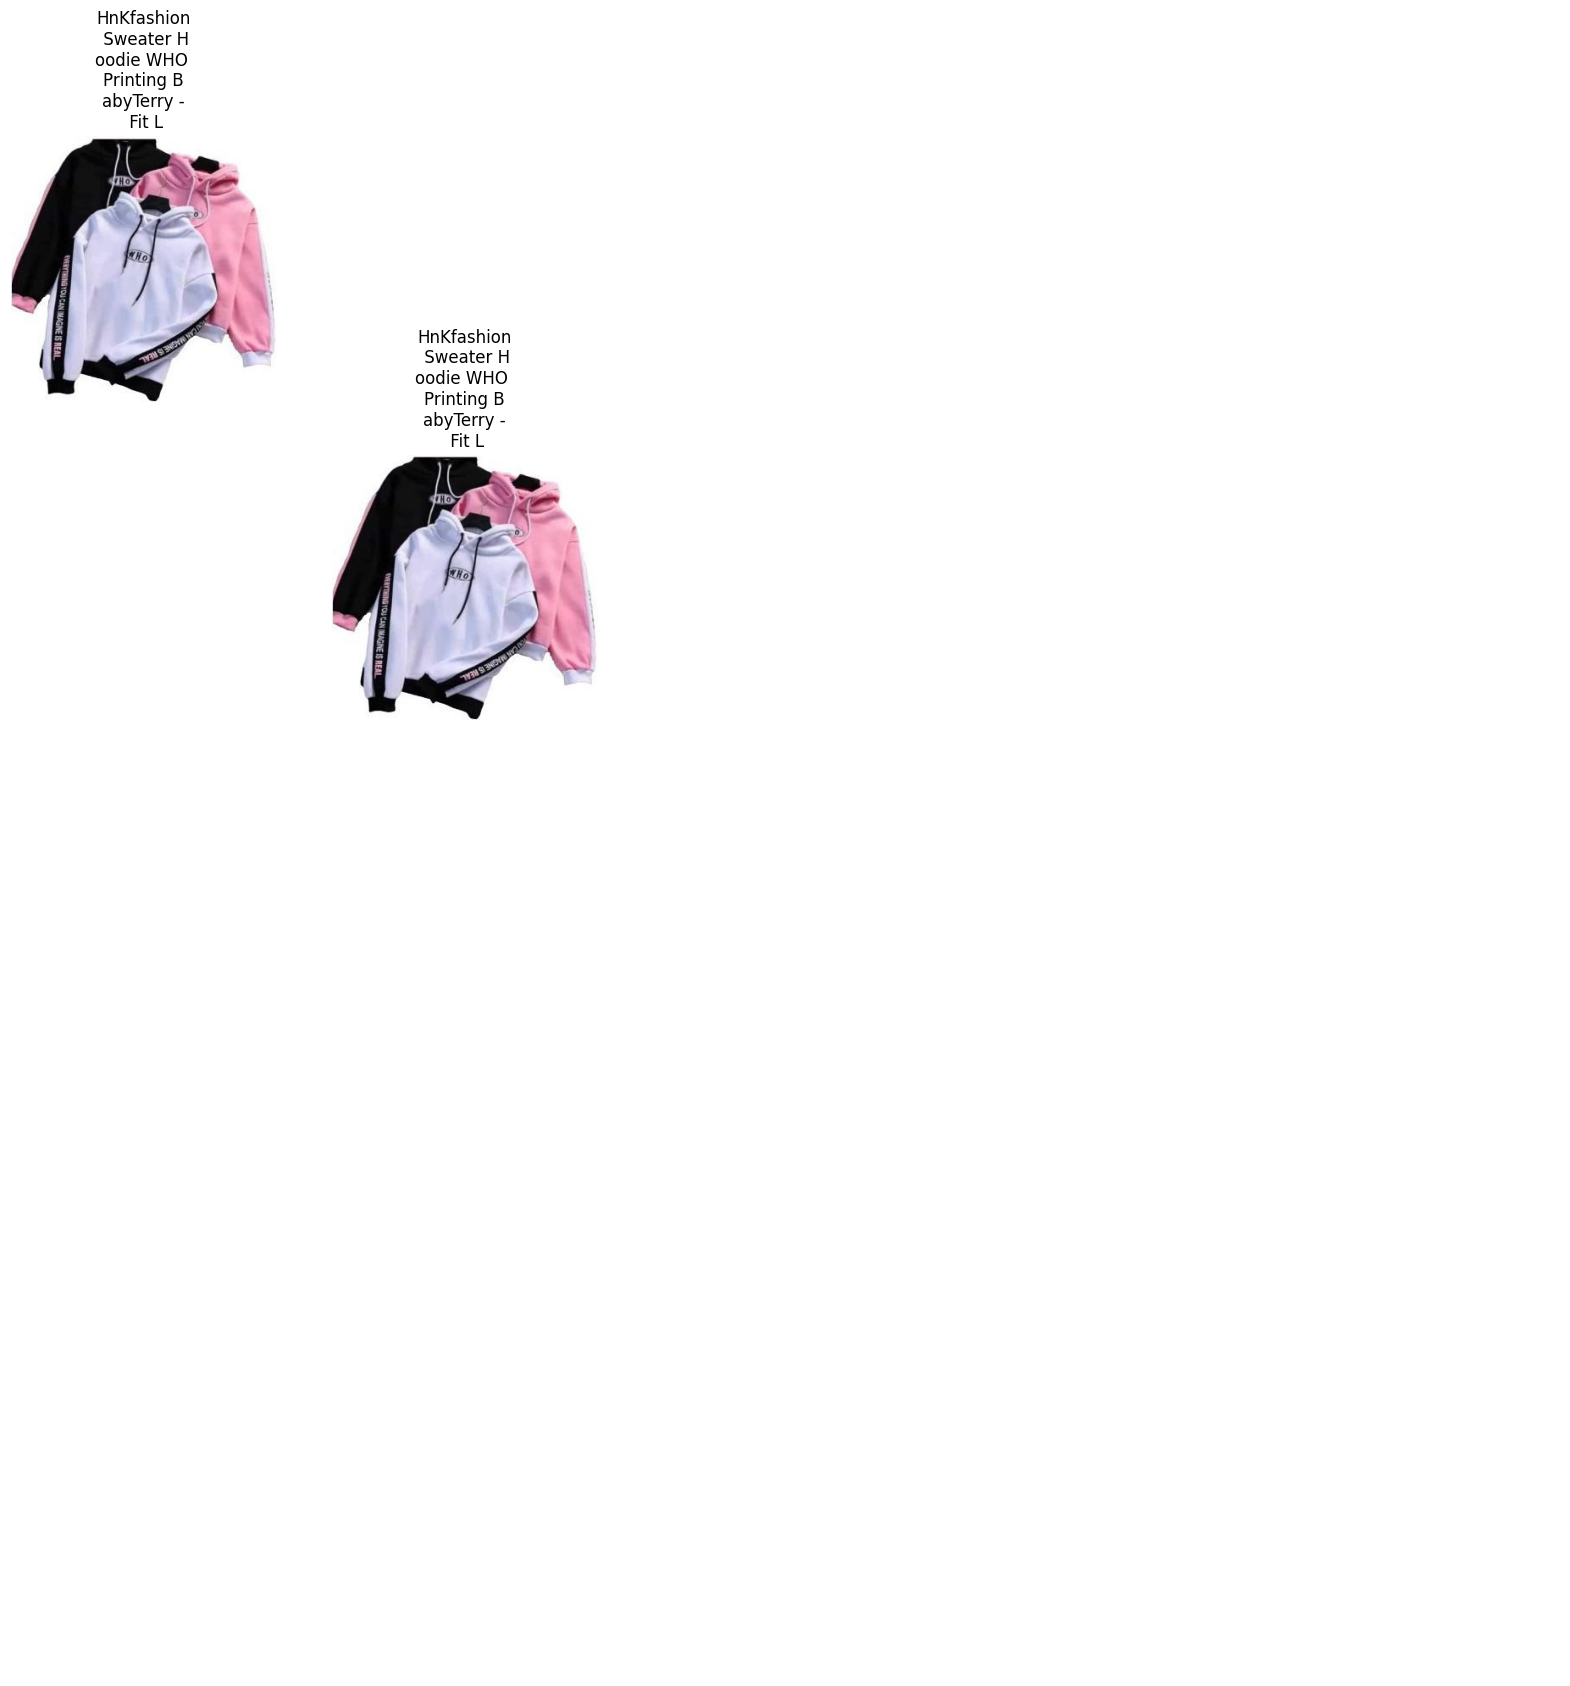

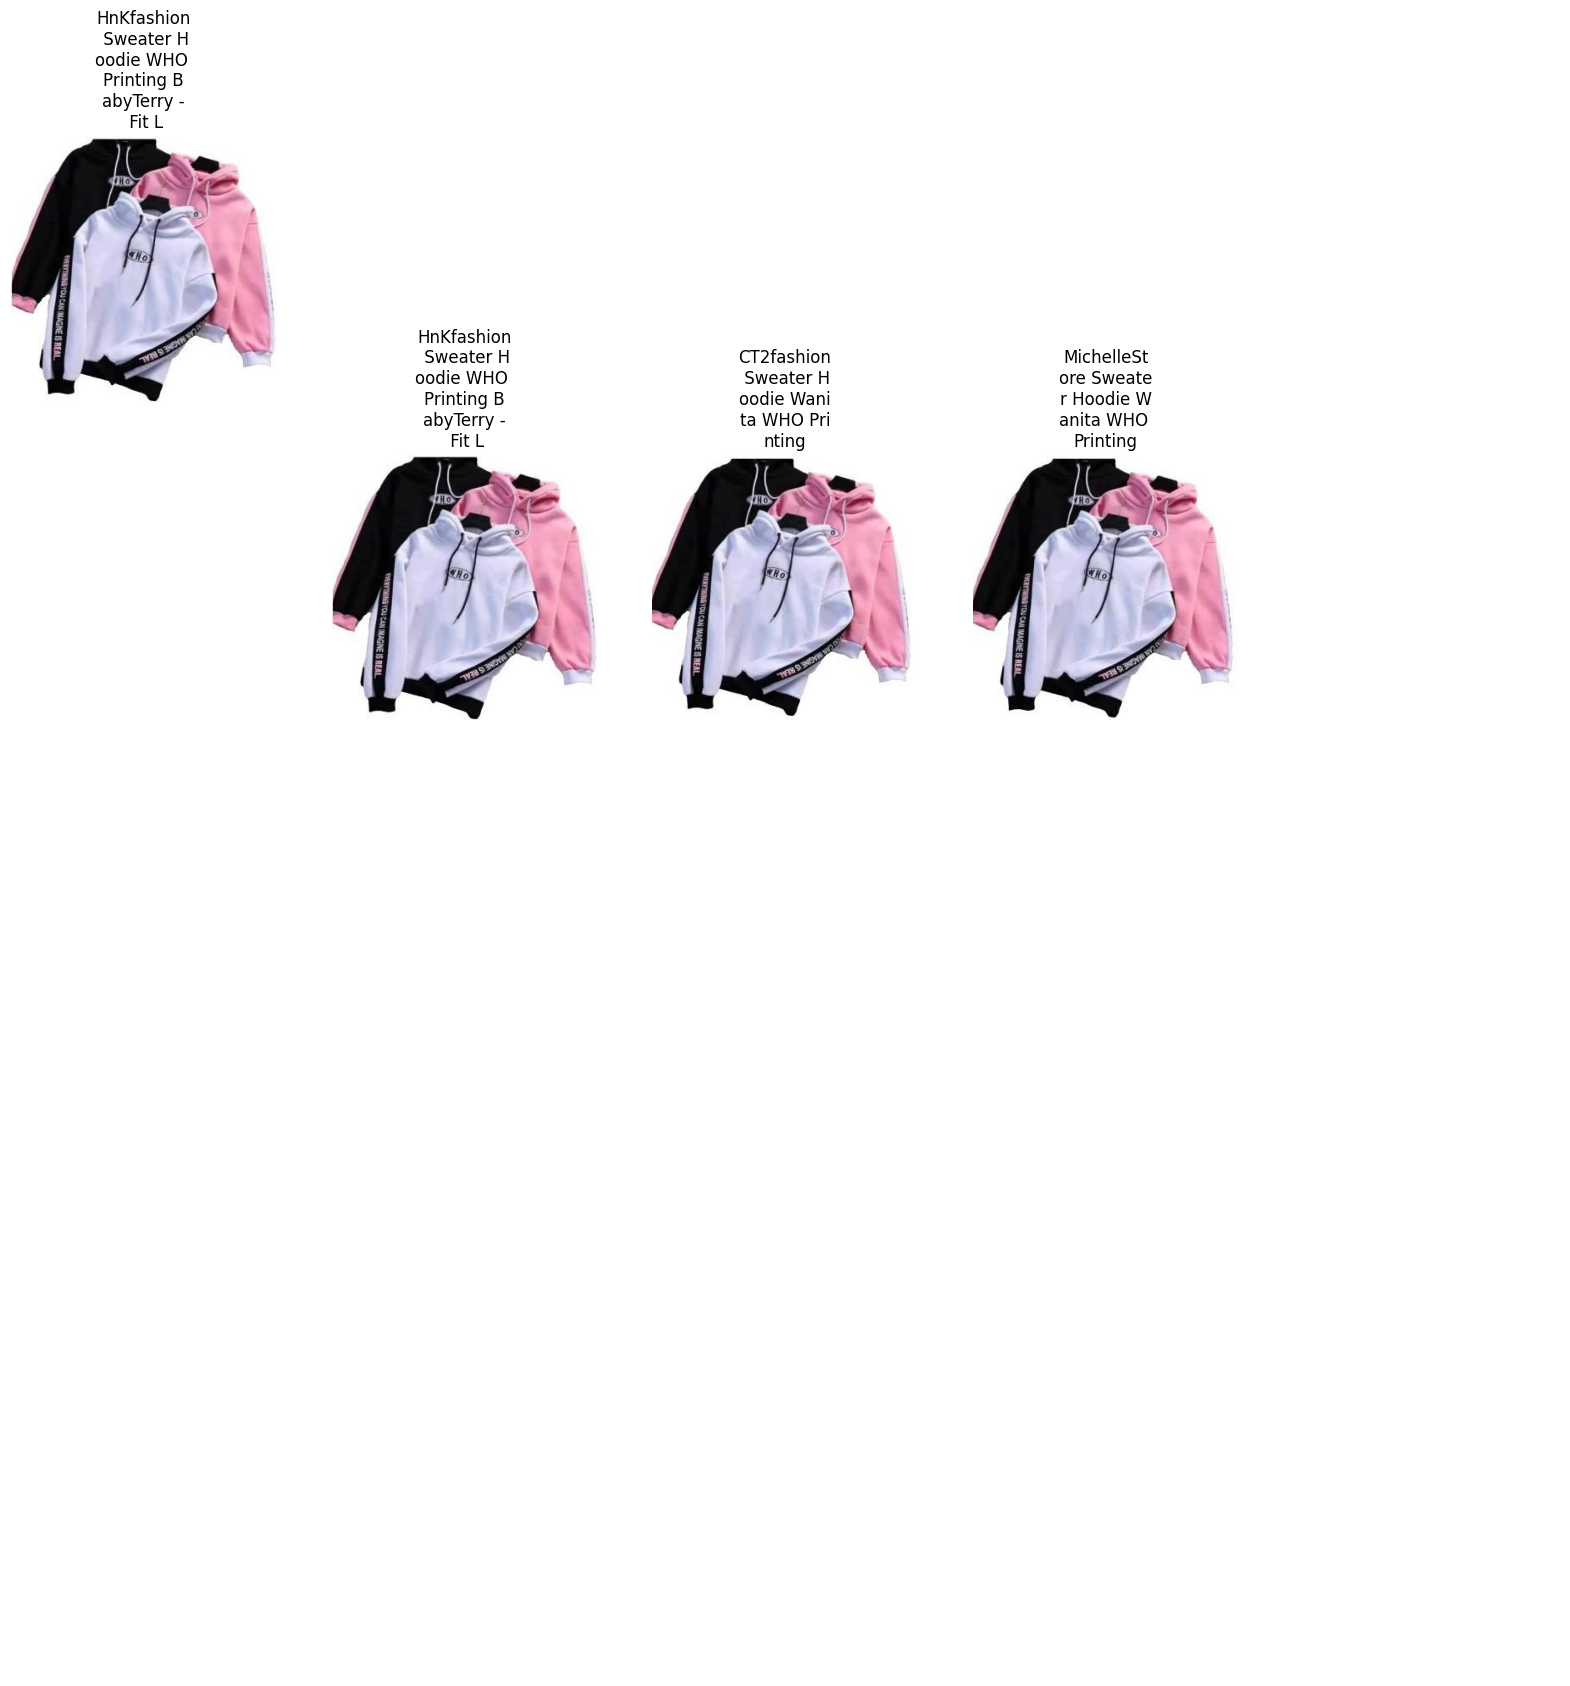

In [42]:
# select the pred where f1 is below 0.6
if CV:
    index = 6
    samples = df[df["f1_visbge"] < 0.6].index.to_list()
    visualize(df, samples[index], "visbge")
    visualize(df, samples[index], "label")

## Submission

In [30]:
def combine(cols):
    def combine_(row):
        return np.unique(np.concatenate([row[col] for col in cols]))

    return combine_


cols = ["phash"]
if use_BGE:
    cols.append("bge")
if use_CLIP:
    cols.append("clip")
if use_VisBGE:
    cols.append("visbge")

df["matches"] = df.apply(combine(cols), axis=1)

In [31]:
if CV:
    df["f1"] = df.apply(compute_f1("matches"), axis=1)
    df["recall"] = df.apply(compute_recall("matches"), axis=1)
    df["precision"] = df.apply(compute_precision("matches"), axis=1)
    df["AP"] = df.apply(compute_AP("matches", 50), axis=1)

    print(
        df.f1.mean(),
        df.recall.mean(),
        df.precision.mean(),
        df.AP.mean(),
    )

0.6998043435948668 0.7724013808645311 0.7600254482884211 0.6929208678359805


In [ ]:
submission = df[["posting_id", "matches"]]
submission["matches"] = submission["matches"].apply(lambda x: " ".join(x))
submission.columns = [["posting_id", "matches"]]
submission

/tmp/ipykernel_689833/3673875693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["matches"] = submission["matches"].apply(lambda x: " ".join(x))


,posting_id,matches
0,train_129225211,train_129225211
1,train_3386243561,train_3386243561
2,train_2288590299,train_2288590299
3,train_2406599165,train_2406599165
4,train_3369186413,train_3369186413
...,...,...
34245,train_4028265689,train_4028265689
34246,train_769054909,train_769054909
34247,train_614977732,train_614977732
34248,train_3630949769,train_3630949769


In [23]:
submission.to_csv("submission.csv", index=False)

In [ ]:
sub = pd.read_csv("/kaggle/working/submission.csv")
sub

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/submission.csv'